## LAB: **ATTENTION IN COMPUTER VISION**

---

***STUDENT(S):*** José Lorente López - DNI: 48842308Z   

---

In the context of machine learning, **attention** is a technique that mimics cognitive attention, defined as the ability to choose and concentrate on relevant stimuli. In other words, **attention is a method that tries to enhance the important parts while fading out the non-relevant information**. The idea of Attention Mechanisms was first popularly introduced in the domain of Natural Language Processing (NLP) in the NeurIPS 2017 paper by Google Brain, titled ["**Attention Is All You Need**"](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

In computer vision, attention has found its way into several applications, such as in the domains of image classification, image segmentation, and image captioning.

<figure>
<center><img src="https://miro.medium.com/max/1400/1*sRy3ukQziKP0TSQqlz3LCg.webp" width="80%"></center> 
<figcaption align = "center"> Attention maps in an image captioning problem. </figcaption>
</figure>

# **CBAM**: Convolutional Block Attention Module 

In this lab we are going to implement one of the most popular attention modules in computer vision: the **Convolutional Block Attention Module (CBAM)**. It contains two sequential sub-modules called the **Channel Attention Module (CAM)** and the **Spatial Attention Module (SAM)**, which are applied in that particular order. The authors of the [paper](https://openaccess.thecvf.com/content_ECCV_2018/papers/Sanghyun_Woo_Convolutional_Block_Attention_ECCV_2018_paper.pdf) point out that CBAM is applied at every convolutional block in deep networks to get subsequent "*Refined Feature Maps*" from the "*Input Intermediate Feature Maps*". 

Before going through the specifics and implementation of Spatial and Channel Attention respectively, let's get to know what these terms mean and why they are essential.

*   ***Spatial*** refers to the domain space encapsulated within each **feature map**. Spatial attention represents the attention mechanism/attention mask on the feature map, or a single cross-sectional slice of the tensor. Refining the feature maps using Spatial Attention, we are **enhancing the input to the subsequent convolutional layers** which thus improves the performance of the model.
*   ***Channel*** attention essentially provides a weight for each channel and thus **enhances those particular channels which are most contributing towards learning** and thus boosts the overall model performance.




# Dataset

In this lab we are going yo apply CBAM in a classification problem. For that, we have selected the [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/), including a white patch to some images (as displayed below). The task is to create a neural network that classifies both types of images.

<figure>
<center><img src="https://miro.medium.com/max/1018/1*rzmgXEF2VJbw6IAB2bA-Cw.webp" width="55%"></center> 
<figcaption align = "center"> STL images. Those images labeled as 1 belong to the class whose images have a white patch while those labeled as 0 are the ones that do not have the white patch.</figcaption>
</figure>

En ML, la "atención" es una técnica que imita la atención humana cognitiva es decir, la capacidad de centrarnos en estímulos relevantes de un objeto según la información que necesitemos del mismo. Es decir, la atención es un método que trata de realzar las partes importantes al tiempo que desvanece la información no relevante.

Esta idea nace del ámbito NLP (Sobretodo del Seq2Seq para mantener el contexto en una frase larga).

En computer vision, la atención se usa para facilitar clasificación, segmentación y subtítulos_semánticos de imágenes.

A lo largo de la práctica, implementaremos uno de los módulos de atención más populares en visión por computador (imágenes), el CBAM. El CBAM, se forma por dos sub-modulos, el CAM y el SAM (que se aplican en este orden). El autor del paper indica que el CBAM se aplica a CADA UNO DE LOS BLOQUES CONVOLUCIONALES en redes profundas.

Utilizaremos a lo largo de este laboratorio CBAM en un problema de clasificación. Usaremos el dataset "STL-10" donde las imágenes (algunas) tendran un rectángulo blanco en ellas (como se puede ver arriba). La idea es crear una red neuronal (con módulos de atención en sus bloques convolucionales) de tal manera que sea capaz de clasificar bien entre ambos tipos de imágenes (1 -> imágenes con un cuadrado blanco en ellas, 0-> imágenes sin un cuadrado blanco en ellas).

# Imports

In [1]:
# Librerías necesarias para el desarrollo de la práctica

import os
from PIL import Image
import torchvision
from torchvision.datasets import STL10
from torchvision import datasets, transforms, utils
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!


d:\anaconda\envs\ids\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\anaconda\envs\ids\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# PART I: Loading and preprocessing STL-10 dataset

Download the STL-10 dataset using torchvision.



Descargamos el dataset "STL-10"

In [3]:
# Original dataset
data_train = STL10("stl10_train", split='train', download=True)
data_test = STL10("stl10_test", split='test', download=True)

Files already downloaded and verified
Files already downloaded and verified


Now we define a dataset class to define the corrupted version of the images and their labels. It takes as input the images from the original dataset.

In [4]:
class STL10_patch(Dataset):

  def __init__(self, dataset_og):

    self.dataset_og = dataset_og

  def __len__(self):
    return len(self.dataset_og)
  
  def __getitem__(self, index):

    image = self.dataset_og.__getitem__(index)[0]

    # Split in image and labels
    stl_image, label = self.corrupt_patch(image) # Devuelve la imágen original (stl_image) y la corrupta (label)
    # Esta función introduce una imagen y con una prob del 50% la corrompe y le pone una etiqueta de 1 o la deja igual y le pone una etiqueta de 0
    # Transform image
    stl_image = self.transform_img(Image.fromarray(stl_image)) # Normaliza la imagen 

    return stl_image, label

  def corrupt_patch(self, img): # Con esta función, creamos la versión corrupta (con el rectángulo) de las imagenes

    img = np.array(img)

    corrupt = np.random.randint(2)

    label = 0.

    if corrupt:
      # Set label to 1 and add the patch
      label = 1.
      pos_x = np.random.randint(96-16)
      pos_y = np.random.randint(96-16)
      img[pos_x:pos_x+16, pos_y:pos_y+16, :] = 1

    return img, torch.tensor(label)

  
  def transform_img(self, image): # Esta función normaliza las imágenes para mejorar el rendimiento computacional

    transform_ops = torchvision.transforms.Compose([
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return transform_ops(image)


Let's show an example from our *corrupted* dataset. We define a method to visualize the images, as they are normalized.

In [5]:
def img_show(img):
    img = img / 2 + 0.5     # unnormalize to plot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [6]:
# 'Corrupted' dataset
trainset = STL10_patch(data_train)
testset = STL10_patch(data_test)

print('Trainset: ', len(trainset))
print('Testset: ', len(testset))

Trainset:  5000
Testset:  8000


Veamos como a las corruptas (label = 1) les falta un trozo de imagen:

IMG shape:  torch.Size([3, 96, 96])


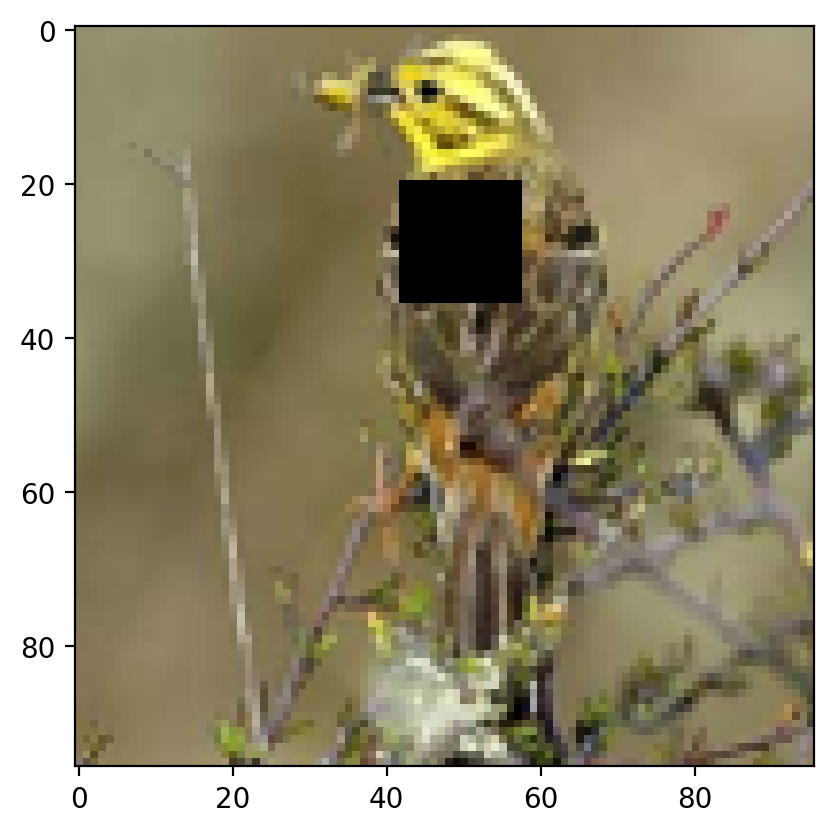

In [9]:
for i in range(len(trainset)):

  img, label_class = trainset.__getitem__(i)

  if label_class == 1:

    print('IMG shape: ', img.shape)
    img_show(img)

    break


Y a las no corruptas (label = 0) no les falta nada:

IMG shape:  torch.Size([3, 96, 96])


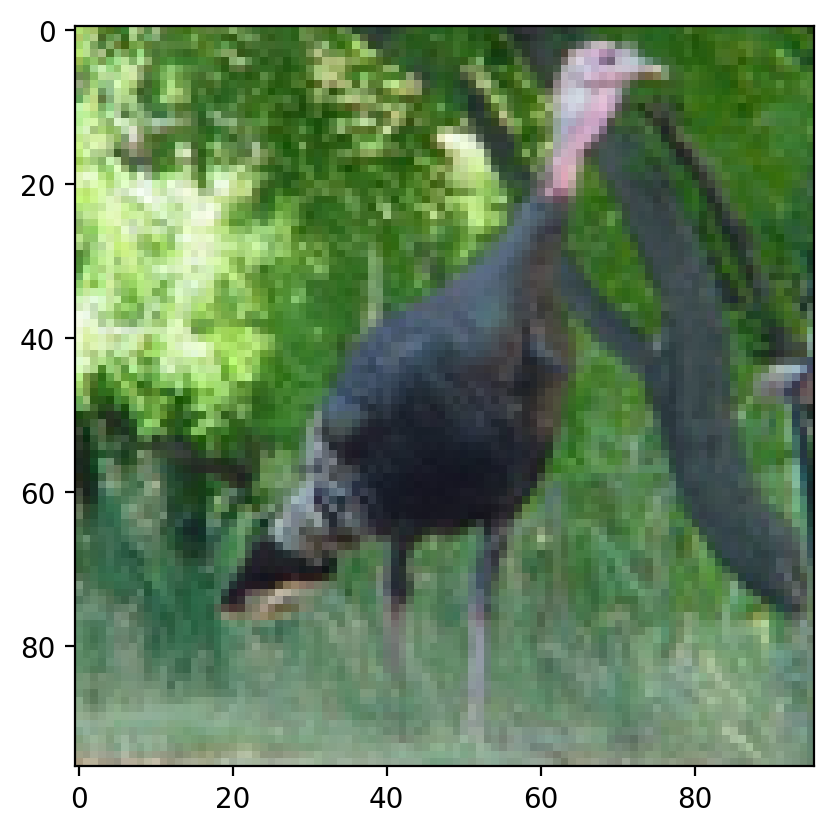

In [10]:
for i in range(len(trainset)):

  img, label_class = trainset.__getitem__(i)

  if label_class == 0:

    print('IMG shape: ', img.shape)
    img_show(img)

    break

One we have defined the Dataset, we can define train and test dataloaders!

In [11]:
batch_size = 32
valid_size = 500

# Training partition
part_tr = torch.utils.data.random_split(trainset, [len(trainset)-valid_size, valid_size])[0]
# Use sampler for randomization
training_sampler = torch.utils.data.SubsetRandomSampler(range(len(part_tr)))
# Define the dataloader
trainloader = torch.utils.data.DataLoader(part_tr, batch_size=batch_size, sampler=training_sampler)

# Validation partition
part_val = torch.utils.data.random_split(trainset, [valid_size, len(trainset)-valid_size])[0]
# Use sampler for randomization
valid_sampler = torch.utils.data.SubsetRandomSampler(range(len(part_val)))
# Define the dataloader
validloader = torch.utils.data.DataLoader(part_val, batch_size=batch_size, sampler=valid_sampler)

# Test partition
# Use sampler for randomization
test_sampler = torch.utils.data.SubsetRandomSampler(range(len(testset)))
# Define the dataloader
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, sampler=test_sampler)

In [12]:
print('TRAIN: ', len(part_tr))
print('VALIDATION: ', len(part_val))
print('TEST: ', len(testset))

TRAIN:  4500
VALIDATION:  500
TEST:  8000


# PART II: Define the CBAM

***SPATIAL ATTENTION MODULE (SAM)***

<figure>
<center><img src="https://blog.paperspace.com/content/images/2020/05/Capture-2.PNG" width="70%"></center> 
</figure>

Spatial Attention Module (SAM) is comprised of a three-fold sequential operation.  

*   **Channel Pool**: the Input Tensor of dimensions `(c × h × w)` is decomposed to 2 channels, i.e. `(2 × h × w)`, where each of the 2 channels represent Max Pooling and Average Pooling across the channels.
*   **Convolution layer** which outputs a 1-channel feature map, i.e., the dimension of the output is `(1 × h × w)`. Thus, this convolution layer is a spatial dimension preserving convolution and uses padding to do the same. In code, the convolution is followed by a Batch Norm layer to normalize and scale the output of convolution. However, the authors have also provided an option to use ReLU activation function after the Convolution layer, but by default it only uses Convolution + Batch Norm.
*   **Sigmoid Activation layer**, which will map all the values to a range between 0 and 1. 

This Spatial Attention mask is then applied to all the feature maps in the input tensor using a simple element-wise product.

> **Exercise**: complete the following code.

Pasemos a crear la CBAM empezando por el módulo SAM:

In [13]:
# 1. Channel Pool
class ChannelPool(nn.Module):

    def forward(self, x):

        out = torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )
        
        return out

In [14]:
# 2. Convolution Layer (+ Batch Normalization + ReLU activation)

class BasicConv(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        
        super(BasicConv, self).__init__()

        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):

        x = self.conv(x)

        if self.bn is not None:
            x = self.bn(x)

        if self.relu is not None:
            x = self.relu(x)

        return x


In [45]:
# === SPATIAL ATTENTION MODULE (SAM) === #

class SpatialGate(nn.Module):

    def __init__(self):

        super(SpatialGate, self).__init__()

        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)

        # NOTE:
        # // -> Divides the number on its left by the number on its right, rounds down the answer, and returns a whole number.

    def forward(self, x):

        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting

        return x * scale

***CHANNEL ATTENTION MODULE (CAM)***

<figure>
<center><img src="https://blog.paperspace.com/content/images/2020/05/Capture-3.PNG" width="70%"></center> 
</figure>

The Channel Attention Module (CAM) is another sequential operation but a bit more complex than Spatial Attention Module (SAM). 

*  It first decomposes the input tensor into 2 subsequent vectors of dimensionality `(c × 1 × 1)`. One of these vectors is generated by **Global Average Pooling (GAP)** while the other vector is generated by **Global Max Pooling (GMP)**. 

    *   **Average Pooling**: aggregates spatial information, it has a smoothing effect.
    *   **Max Pooling**: it preserves much richer contextual information in the form of edges of the object within the image which thus leads to finer channel attention. It preserves natural edges of the objects more precisely.

*  This vector is passed to a **Multi Layer Perceptron (MLP)** network which has a bottleneck whose width or number of neurons is decided by the reduction ratio (r). The higher the reduction ratio, the fewer the number of neurons in the bottleneck and vice versa.

*   The output is the passed to a **Sigmoid activation layer** which then maps the values within the range of 0 and 1.

> **Exercise**: complete the following code.


Creamos el modulo CAM:

In [46]:
# AUXILIAR MODULE

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [47]:
# === CHANNEL ATTENTION MODULE (CAM) === #

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16):

        super(ChannelGate, self).__init__()

        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )

    def forward(self, x):

        channel_att_sum = None

        avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
        channel_att_avg = self.mlp(avg_pool)

        max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
        channel_att_max = self.mlp(max_pool)

        channel_att = channel_att_avg + channel_att_max

        scale = F.sigmoid(channel_att).unsqueeze(2).unsqueeze(3).expand_as(x) # mask for the three channels

        return x * scale

***COMPLETE CBAM!***
> **Exercise**: complete the following code.

Creamos la CBAM al completo:

In [48]:
# === CONVOLUTIONAL BLOCK ATTENTION MODULE (CBAM) === #

class CBAM(nn.Module):

    def __init__(self, gate_channels, reduction_ratio=16, no_spatial=False):
        super(CBAM, self).__init__()

        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio)
        self.no_spatial=no_spatial

        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):

        x_out = self.ChannelGate(x)

        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
            
        return x_out

**CBAM** is applied as a layer in every convolutional block of a convolutional neural network model. It takes in a tensor containing the feature maps from the previous convolutional layer and first refines it by applying channel attention using **CAM**. Subsequently this refined tensor is passed to **SAM** where the spatial attention is applied, thus resulting in the output refined feature maps. 

Now let's define a simple network including CBAM.

> **Exercise**: complete the following code.

Generamos una red convolucional con atención usando la CBAM:

In [49]:
# Convolutional block
class ConvPart(nn.Module):

    def __init__(self):

        super().__init__()

        # Convolution and Max Pooling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)

        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.pool2(out)

        out = self.conv3(out)

        return out

In [50]:
# Full network including CBAM
class NetCBAM(nn.Module):

    def __init__(self, gate_channels=32):

        super().__init__()

        self.gate_channels = gate_channels

        # NN Blocks
        self.conv = ConvPart()
        self.attn1 = CBAM(gate_channels=self.gate_channels)
        self.linear = nn.Linear(self.gate_channels, 1)

    def forward(self, x):

        out_conv = self.conv.forward(x)
        out_attn = self.attn1.forward(out_conv)
        out = out_attn.mean(3).mean(2)
        out =self.linear.forward(out)
        out = torch.sigmoid(out)[:,0]

        return out, out_attn

The following class completes the implementation of our network, extending it with a training method.

> **Exercise**: complete the following code.

In [51]:
class NetCBAM_extended(NetCBAM):

    def __init__(self, gate_channels=32, lr=1e-3,epochs=20):

        super().__init__(gate_channels = gate_channels)

        # TRAINING VARIABLES
        self.lr = lr    
        self.optim = optim.Adam(self.parameters(), self.lr)   
        self.epochs = epochs

        # CRITERION
        self.criterion = nn.BCELoss()

        # LOSS EVOLUTION
        self.loss_during_training = []
        self.valid_loss_during_training = []

        # GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)


    def trainloop(self, trainloader, validloader):

        self.train()

        for e in range(int(self.epochs)):

          running_loss = 0.

          for images, labels in trainloader:

            images = images.to(self.device)
            labels = labels.to(self.device)

            self.optim.zero_grad()

            pred, _ = self.forward(images)

            loss = self.criterion(pred,labels)

            loss.backward()

            self.optim.step()

            running_loss += loss.item()

          self.loss_during_training.append(running_loss/len(trainloader))

          # Validation
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():            
              
              running_loss = 0.
              
              for images,labels in validloader:

                  images = images.to(self.device)
                  labels = labels.to(self.device)
                  
                  pred, _ = self.forward(images)

                  loss = self.criterion(pred,labels)

                  running_loss += loss.item()  
                  
              self.valid_loss_during_training.append(running_loss/len(validloader))

          print('\nTrain Epoch: {} -> Training Loss: {:.6f}'.format(e,self.loss_during_training[-1]))
          print('Train Epoch: {} -> Validation Loss: {:.6f}'.format(e,self.valid_loss_during_training[-1]))

    def eval_performance(self, dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 
                probs, _ = self.forward(images)

                labels_pred = torch.round(probs)
                equals = (labels_pred == labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

> **Exercise**: Train the model for 30 epochs. Plot the evolution of train and validation losses. Is the network overfitting?

In [52]:
n_epochs = 30
my_CBAM = NetCBAM_extended(gate_channels=32, lr=1e-3, epochs=30)
my_CBAM.trainloop(trainloader,validloader)

d:\anaconda\envs\ids\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Train Epoch: 0 -> Training Loss: 0.448676
Train Epoch: 0 -> Validation Loss: 0.130346

Train Epoch: 1 -> Training Loss: 0.101352
Train Epoch: 1 -> Validation Loss: 0.085977

Train Epoch: 2 -> Training Loss: 0.091859
Train Epoch: 2 -> Validation Loss: 0.063002

Train Epoch: 3 -> Training Loss: 0.085269
Train Epoch: 3 -> Validation Loss: 0.088578

Train Epoch: 4 -> Training Loss: 0.048872
Train Epoch: 4 -> Validation Loss: 0.026480

Train Epoch: 5 -> Training Loss: 0.054486
Train Epoch: 5 -> Validation Loss: 0.041744

Train Epoch: 6 -> Training Loss: 0.047488
Train Epoch: 6 -> Validation Loss: 0.023075

Train Epoch: 7 -> Training Loss: 0.041665
Train Epoch: 7 -> Validation Loss: 0.081964

Train Epoch: 8 -> Training Loss: 0.045718
Train Epoch: 8 -> Validation Loss: 0.180883

Train Epoch: 9 -> Training Loss: 0.059905
Train Epoch: 9 -> Validation Loss: 0.035648

Train Epoch: 10 -> Training Loss: 0.049612
Train Epoch: 10 -> Validation Loss: 0.044950

Train Epoch: 11 -> Training Loss: 0.0375

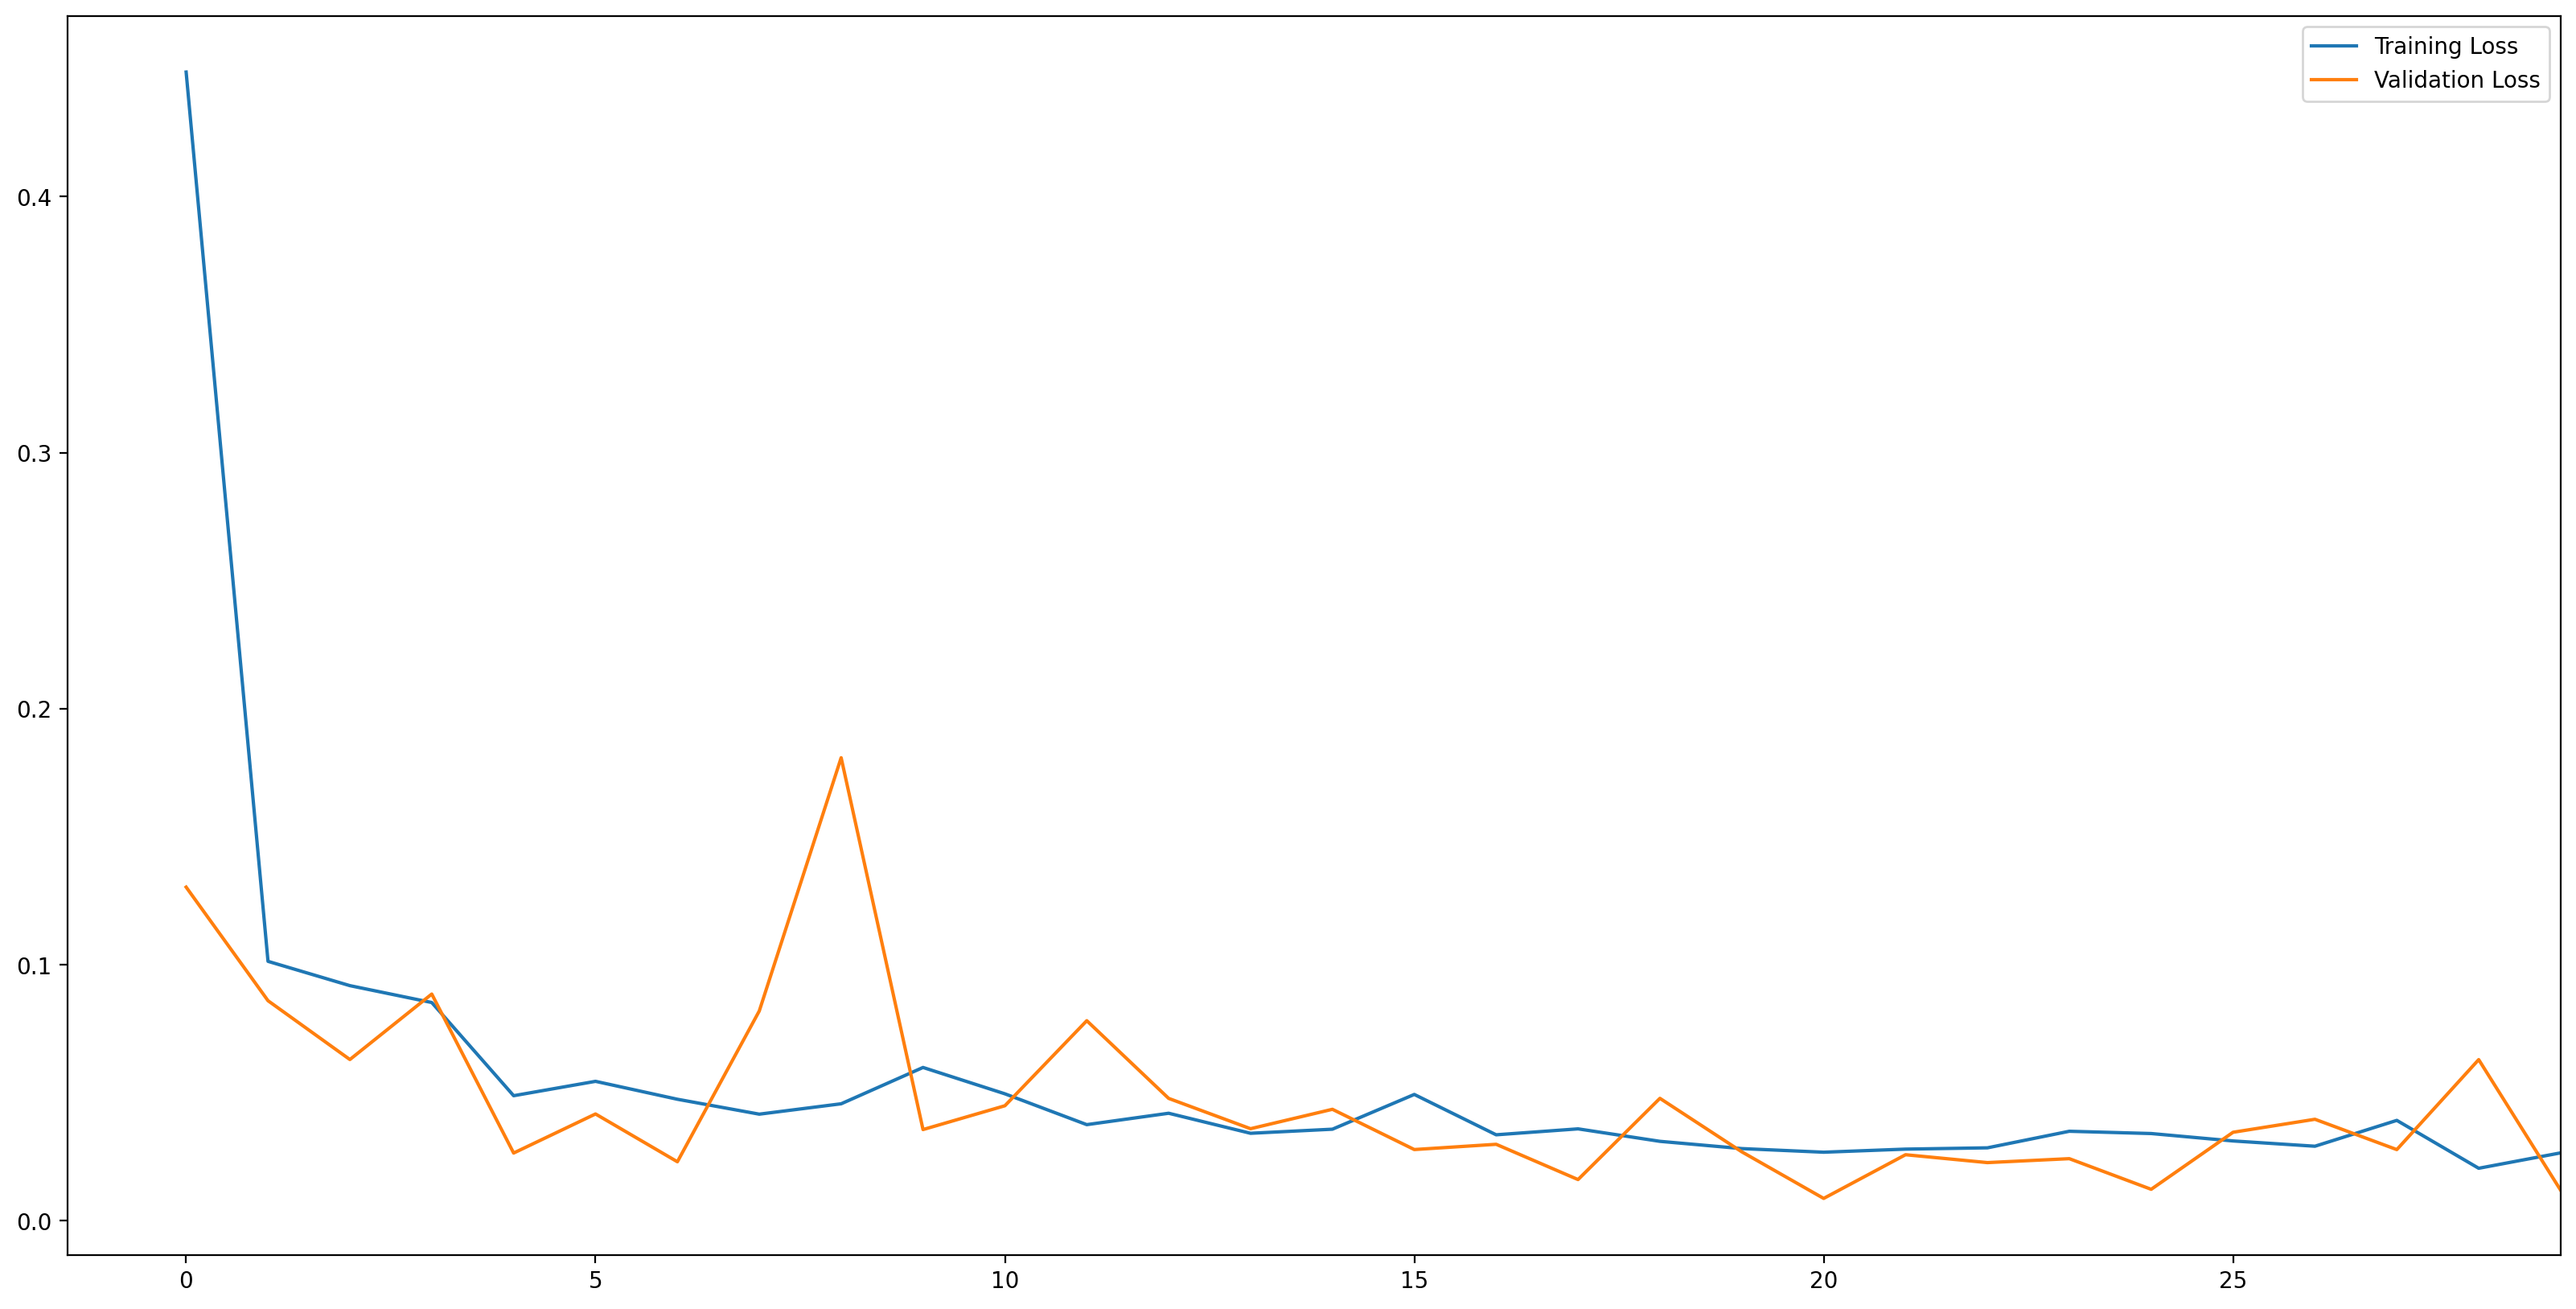

In [53]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_CBAM.loss_during_training,label='Training Loss')
ax.plot(my_CBAM.valid_loss_during_training,label='Validation Loss')
ax.legend()
ax.set_xlim(right=29)
fig.set_facecolor('white')

La red a lo largo de las 30 primeras épocas no tiende a overfitear (de hecho, ambas funciones, tanto la de entrenamiento como la de validación, siguen descendiendo) sin embargo vemos ciertos picos irregulares en el conjunto de validación según la partición que se tome.

> **Exercise**: Evaluate the performance of the model in the different data partitions.

In [55]:
# YOUR CODE HERE
print('El accuracy obtenido sobre el conjunto de entrenamiento es de: ' + str(my_CBAM.eval_performance(trainloader)*100) + '%')
print('El accuracy obtenido sobre el conjunto de validación es de: ' + str(my_CBAM.eval_performance(validloader)*100) + '%')
print('El accuracy obtenido sobre el conjunto de test es de: ' + str(my_CBAM.eval_performance(testloader)*100) + '%')

El accuracy obtenido sobre el conjunto de entrenamiento es de: tensor(99.3573)%
El accuracy obtenido sobre el conjunto de validación es de: tensor(99.6094)%
El accuracy obtenido sobre el conjunto de test es de: tensor(99.1125)%


De todos modos, y como podemos ver aquí, los resultados en accuracy son extremadamente buenos. Vemos como añadiendo el módulo de atención, la clasificación de las imágenes se simplifica al extremo y se convierte en un problema binario realmente sencillo para la red.

> **Exercise**: complete the following code to visualize some of the obtaines attention maps. Discuss the obtained results.

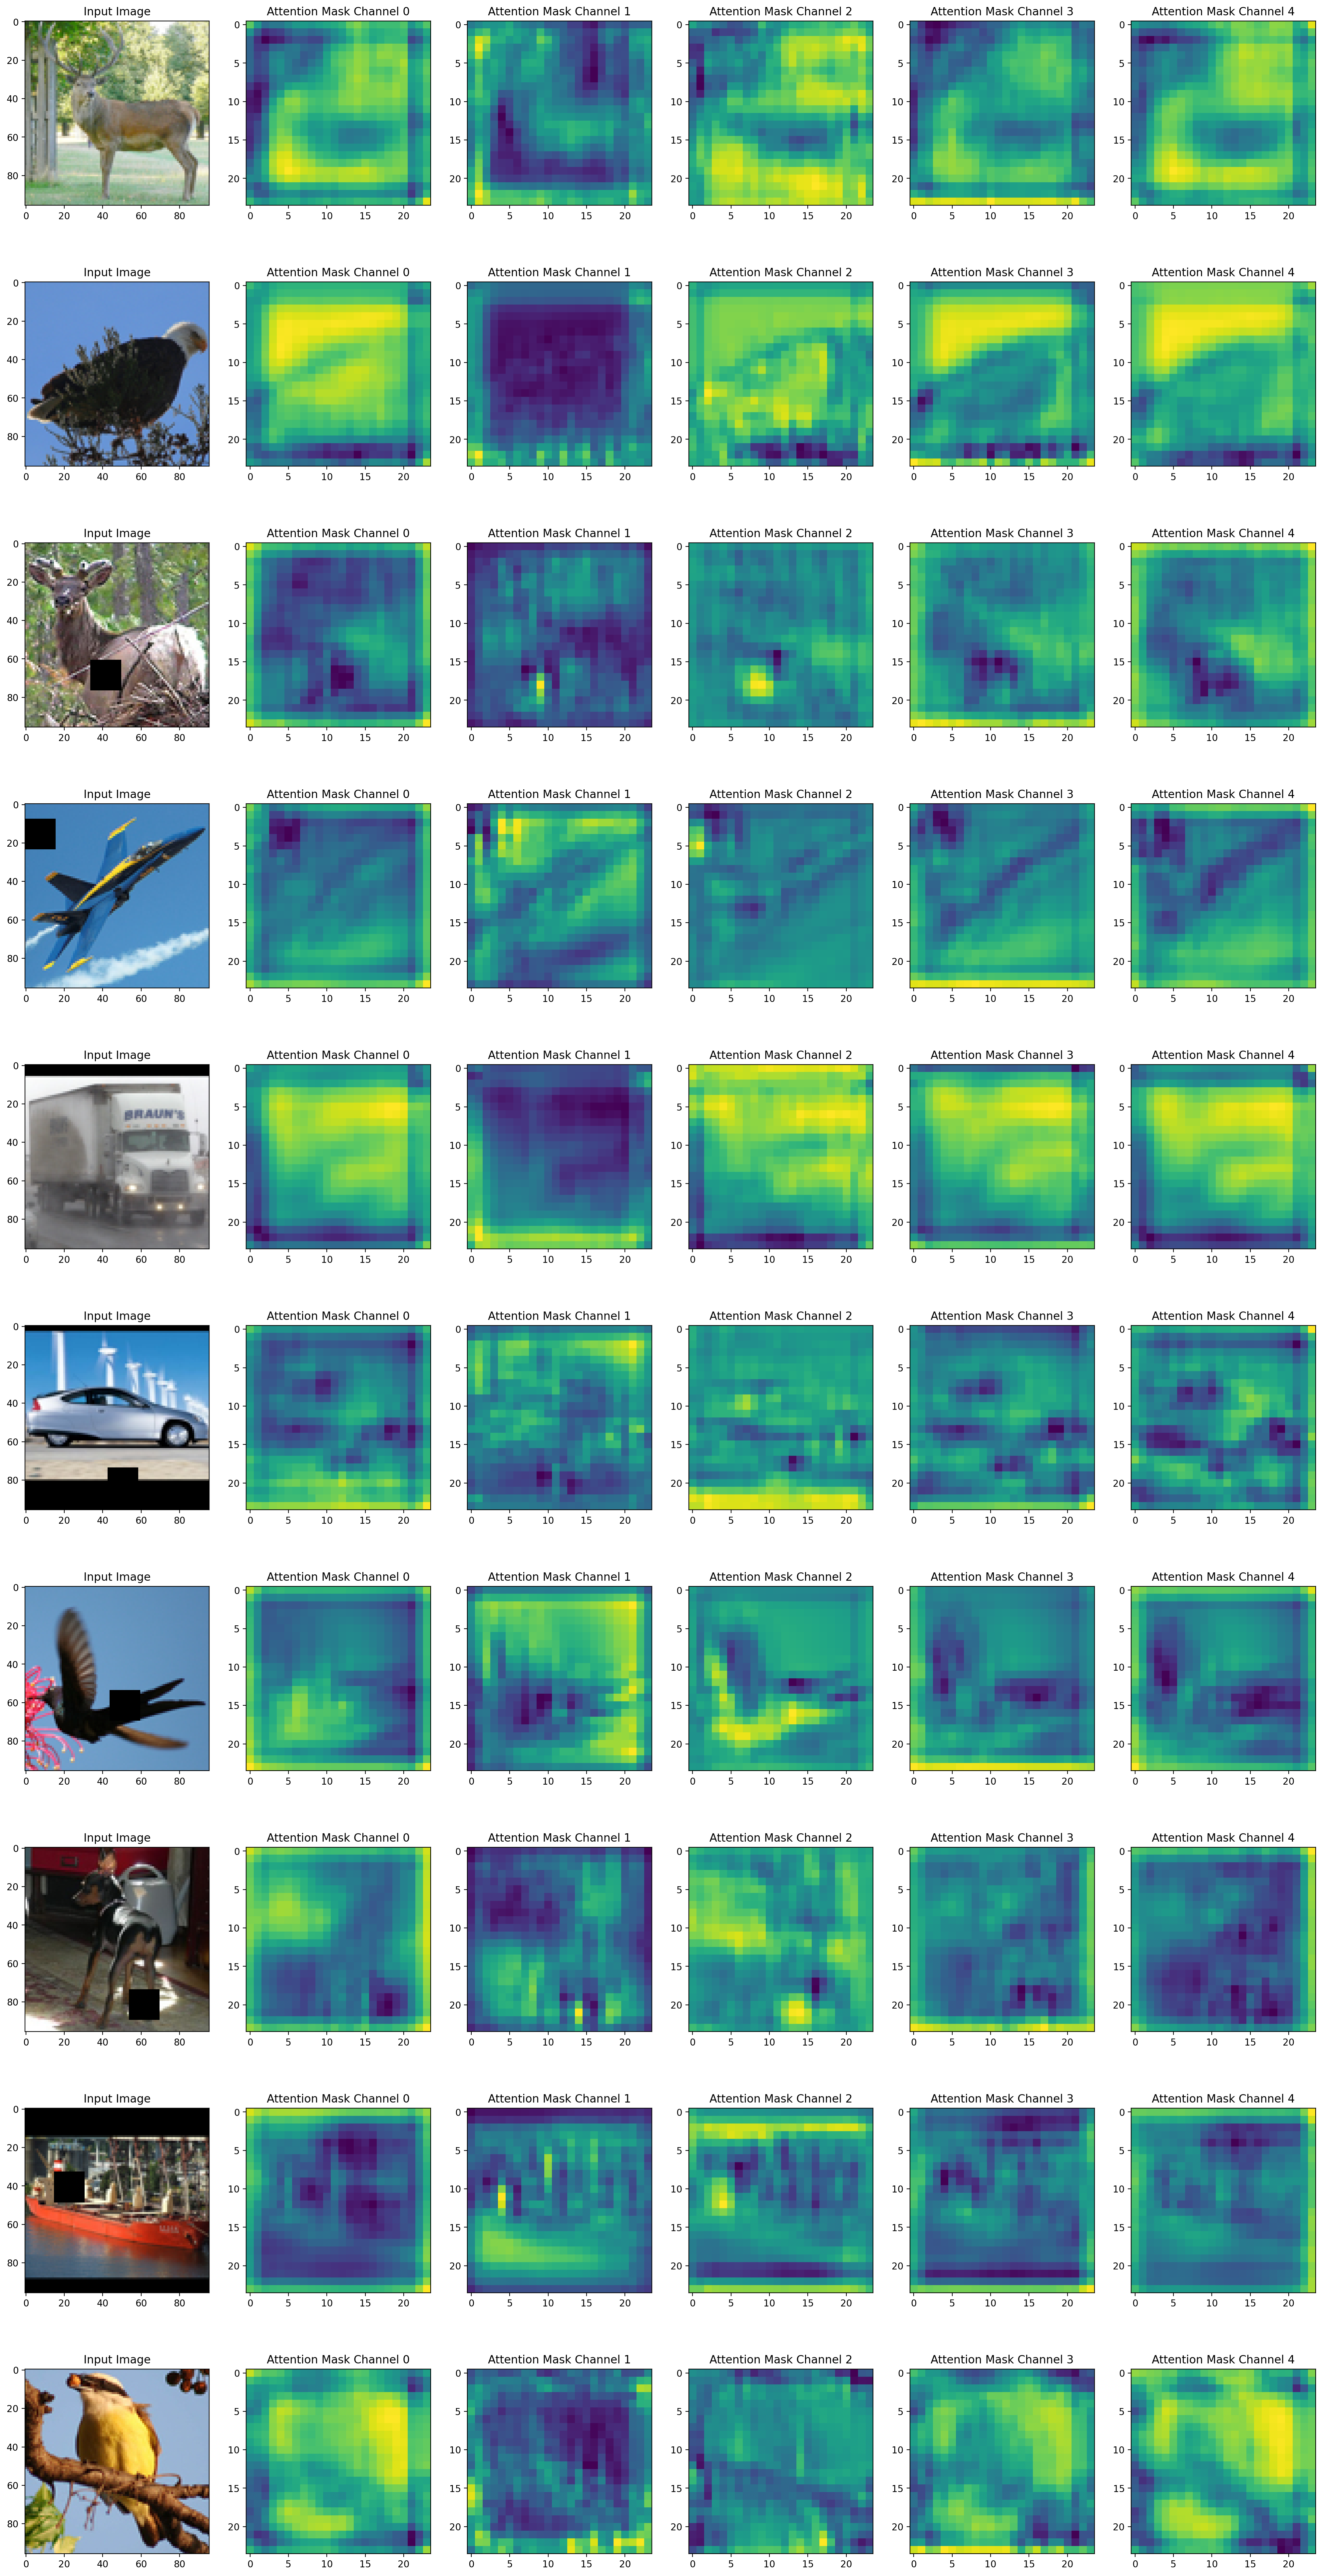

In [60]:
img, labels = next(iter(testloader))
#img, labels = img.to(my_cbam.device), labels.to(my_cbam.device)

_, attn = my_CBAM.forward(img)


fig, axes = plt.subplots(10, 6, figsize=(5*5, 10*5))

for i in range(10):
    img_plot = np.transpose(img[i,:,:,:].cpu().detach().numpy(), (1, 2, 0))
    img_plot = img_plot / 2 + 0.5
    axes[i, 0].imshow(img_plot)
    axes[i, 0].set_title("Input Image")
    axes[i, 1].imshow(attn[i,0,:,:].cpu().detach().numpy())
    axes[i, 1].set_title("Attention Mask Channel 0")
    axes[i, 2].imshow(attn[i,1,:,:].cpu().detach().numpy())
    axes[i, 2].set_title("Attention Mask Channel 1")
    axes[i, 3].imshow(attn[i,2,:,:].cpu().detach().numpy())
    axes[i, 3].set_title("Attention Mask Channel 2")
    axes[i, 4].imshow(attn[i,3,:,:].cpu().detach().numpy())
    axes[i, 4].set_title("Attention Mask Channel 3")
    axes[i, 5].imshow(attn[i,4,:,:].cpu().detach().numpy())
    axes[i, 5].set_title("Attention Mask Channel 4")


Vemos como, para cada imagen, siempre contamos con un mapa que consigue enfocarse (ya sea con valores muy positivos o muy negativos) en el objeto relevante de la misma. Y, en caso de contar con la imperfección, realzar la misma para facilitar la clasificación.

En las imágenes sin imperfecciones, se centra en los colores negros (ya que los cuadrados de imperfección son negros). Con esta información comprobamos que la red sabe en que centrarse (lógicamente en las imperfecciones) para clasificar correctamente.

> **OPTIONAL EXERCISE**: compare the results obtained using the CBAM block with the ones obtained using a network that hasn't attention.

Generamos la misma red pero quitando el modulo de atención:

In [62]:
# Convolutional block
class ConvPart(nn.Module):

    def __init__(self):

        super().__init__()

        # Convolution and Max Pooling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)

        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.pool2(out)

        out = self.conv3(out)

        return out

In [69]:
# Full network including CBAM
class CBAM_No_Attention(nn.Module):

    def __init__(self, gate_channels=32):

        super().__init__()

        self.gate_channels = gate_channels

        # NN Blocks
        self.conv = ConvPart()
        self.attn1 = CBAM(gate_channels=self.gate_channels)
        self.linear = nn.Linear(self.gate_channels, 1)

    def forward(self, x):

        out_conv = self.conv.forward(x)
        out = out_conv.mean(3).mean(2)
        out = self.linear.forward(out)
        out = torch.sigmoid(out)[:,0]

        return out

In [70]:
class CBAM_No_Attention_extended(CBAM_No_Attention):

    def __init__(self, gate_channels=32, lr=1e-3,epochs=20):

        super().__init__(gate_channels = gate_channels)

        # TRAINING VARIABLES
        self.lr = lr    
        self.optim = optim.Adam(self.parameters(), self.lr)   
        self.epochs = epochs

        # CRITERION
        self.criterion = nn.BCELoss()

        # LOSS EVOLUTION
        self.loss_during_training = []
        self.valid_loss_during_training = []

        # GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)


    def trainloop(self, trainloader, validloader):

        self.train()

        for e in range(int(self.epochs)):

          running_loss = 0.

          for images, labels in trainloader:

            images = images.to(self.device)
            labels = labels.to(self.device)

            self.optim.zero_grad()

            pred = self.forward(images)

            loss = self.criterion(pred,labels)

            loss.backward()

            self.optim.step()

            running_loss += loss.item()

          self.loss_during_training.append(running_loss/len(trainloader))

          # Validation
          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():            
              
              running_loss = 0.
              
              for images,labels in validloader:

                  images = images.to(self.device)
                  labels = labels.to(self.device)
                  
                  pred = self.forward(images)

                  loss = self.criterion(pred,labels)

                  running_loss += loss.item()  
                  
              self.valid_loss_during_training.append(running_loss/len(validloader))

          print('\nTrain Epoch: {} -> Training Loss: {:.6f}'.format(e,self.loss_during_training[-1]))
          print('Train Epoch: {} -> Validation Loss: {:.6f}'.format(e,self.valid_loss_during_training[-1]))

    def eval_performance(self, dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 
                probs = self.forward(images)

                labels_pred = torch.round(probs)
                equals = (labels_pred == labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [71]:
n_epochs = 30
my_CBAM_NoAttention = CBAM_No_Attention_extended(gate_channels=32, lr=1e-3, epochs=30)
my_CBAM_NoAttention.trainloop(trainloader,validloader)


Train Epoch: 0 -> Training Loss: 0.700904
Train Epoch: 0 -> Validation Loss: 0.687856

Train Epoch: 1 -> Training Loss: 0.689154
Train Epoch: 1 -> Validation Loss: 0.672894

Train Epoch: 2 -> Training Loss: 0.684213
Train Epoch: 2 -> Validation Loss: 0.686080

Train Epoch: 3 -> Training Loss: 0.676514
Train Epoch: 3 -> Validation Loss: 0.674773

Train Epoch: 4 -> Training Loss: 0.673639
Train Epoch: 4 -> Validation Loss: 0.681410

Train Epoch: 5 -> Training Loss: 0.667350
Train Epoch: 5 -> Validation Loss: 0.664077

Train Epoch: 6 -> Training Loss: 0.649824
Train Epoch: 6 -> Validation Loss: 0.629134

Train Epoch: 7 -> Training Loss: 0.636032
Train Epoch: 7 -> Validation Loss: 0.647746

Train Epoch: 8 -> Training Loss: 0.604157
Train Epoch: 8 -> Validation Loss: 0.585919

Train Epoch: 9 -> Training Loss: 0.561957
Train Epoch: 9 -> Validation Loss: 0.601362

Train Epoch: 10 -> Training Loss: 0.526677
Train Epoch: 10 -> Validation Loss: 0.480607

Train Epoch: 11 -> Training Loss: 0.4614

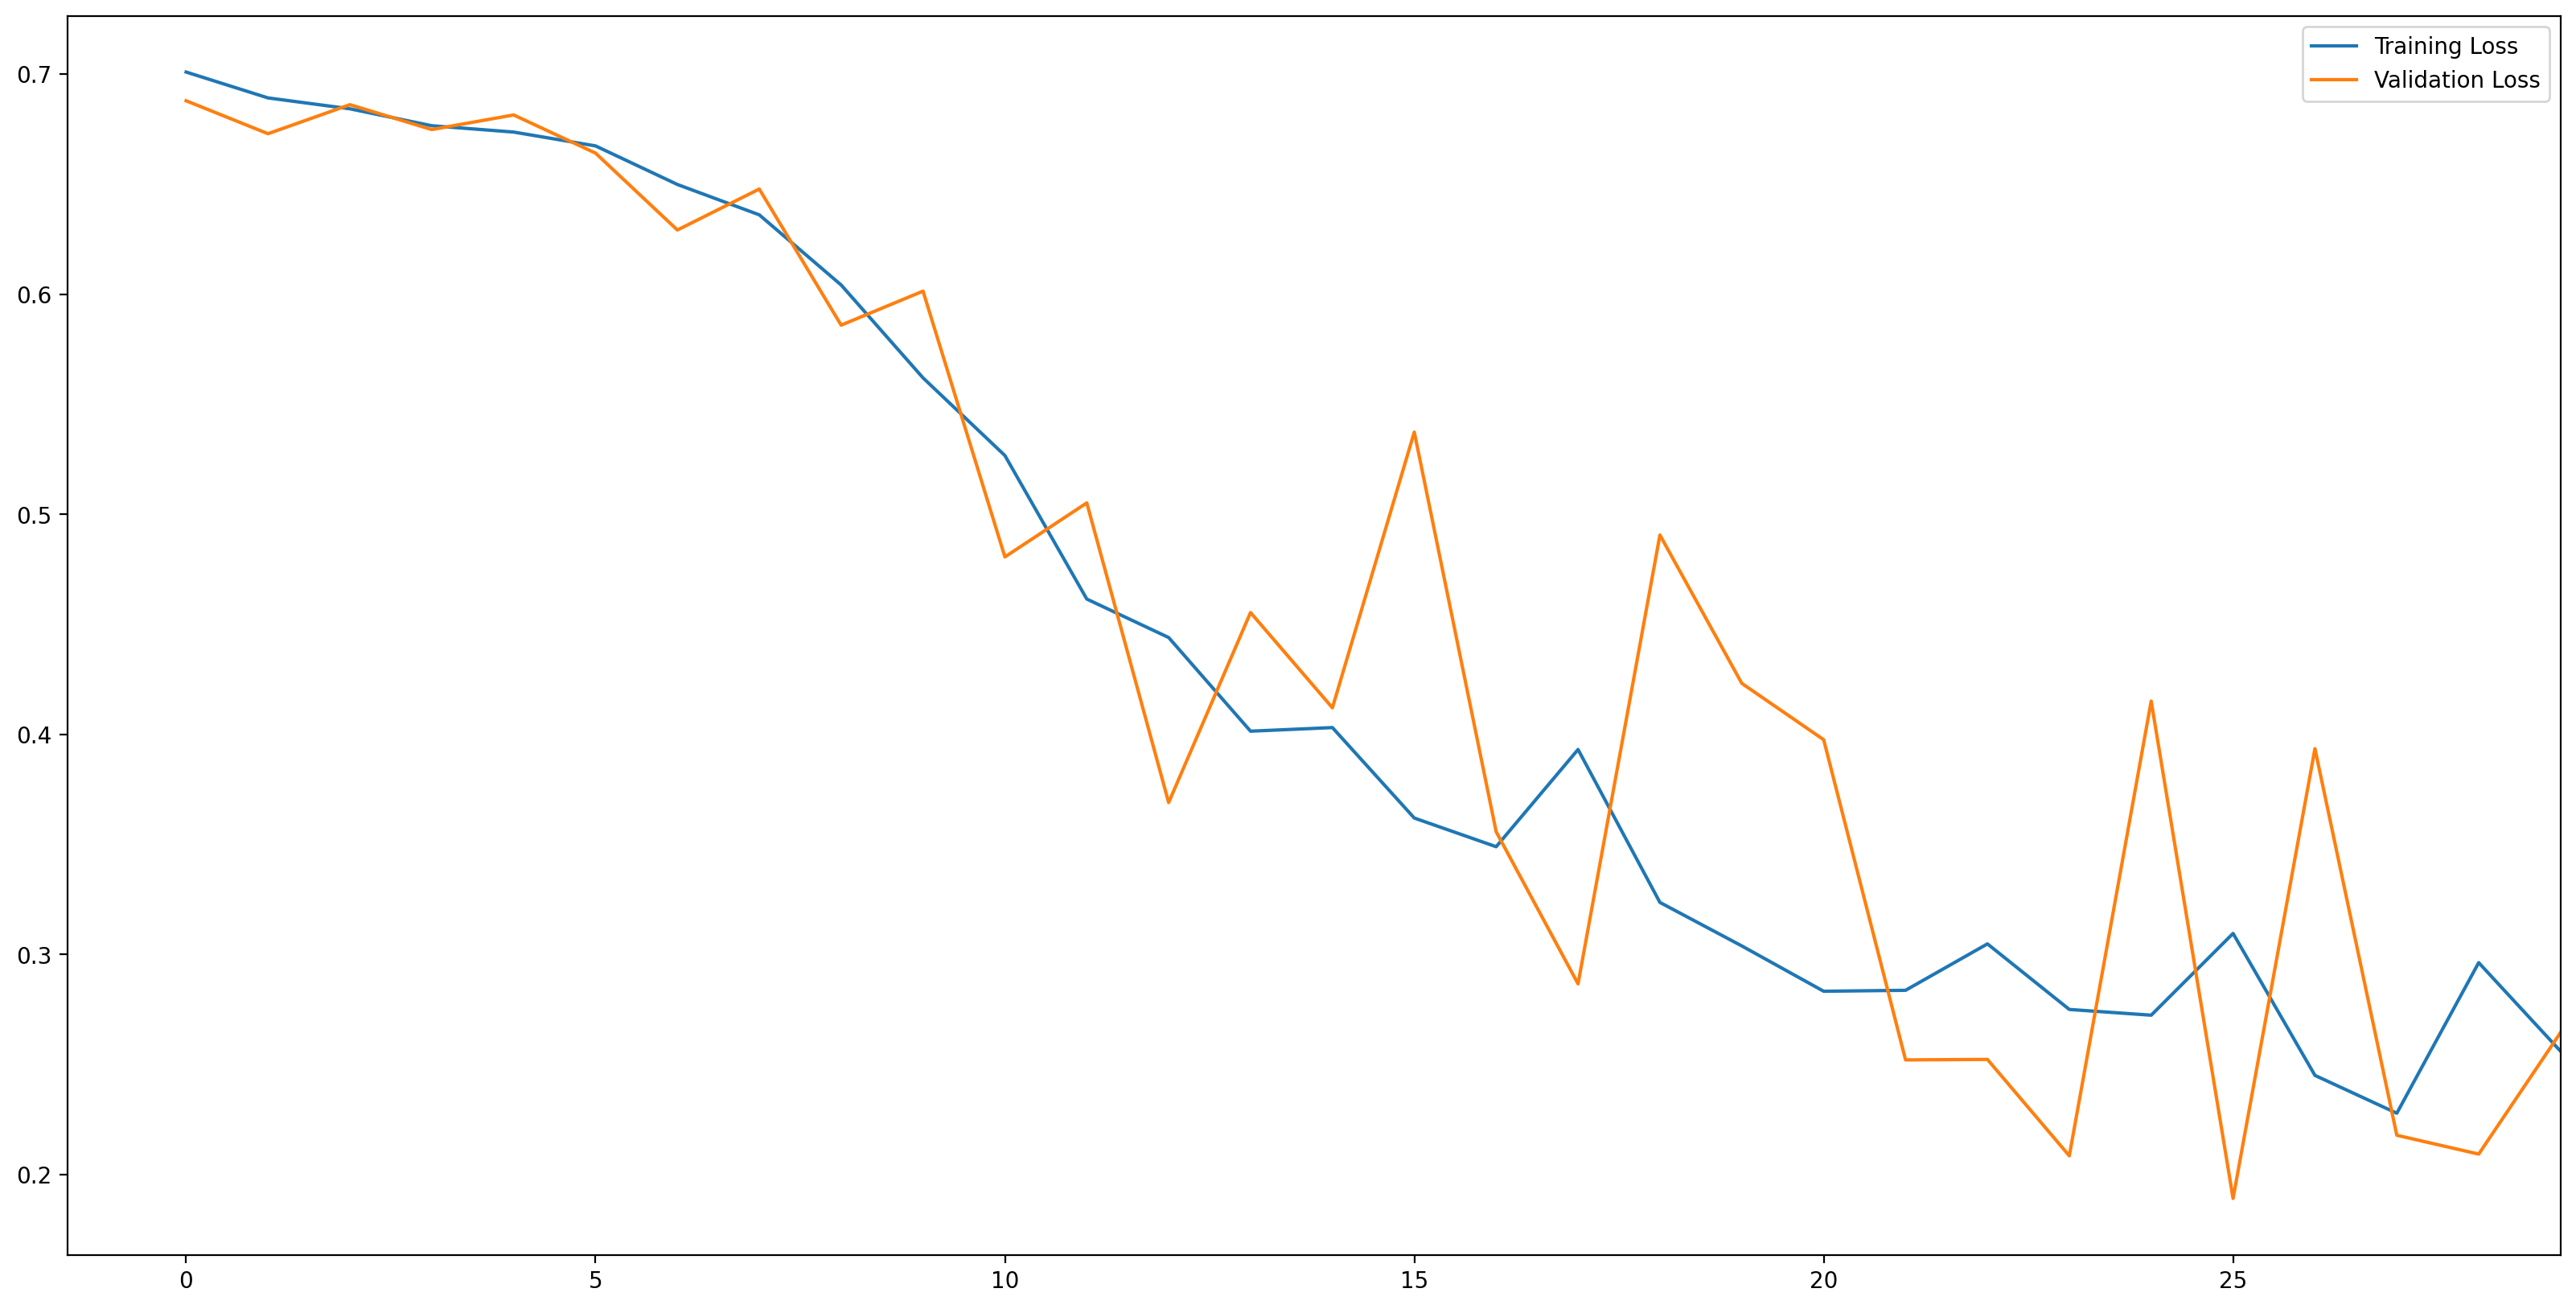

In [72]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_CBAM_NoAttention.loss_during_training,label='Training Loss')
ax.plot(my_CBAM_NoAttention.valid_loss_during_training,label='Validation Loss')
ax.legend()
ax.set_xlim(right=29)
fig.set_facecolor('white')

Como es lógico, los resultados son relativamente peores y vemos aún más picos irregulares en el entrenamiento del conjunto de validación.

In [74]:
# YOUR CODE HERE
print('El accuracy obtenido sobre el conjunto de entrenamiento es de: ' + str(my_CBAM_NoAttention.eval_performance(trainloader)*100) + '%')
print('El accuracy obtenido sobre el conjunto de validación es de: ' + str(my_CBAM_NoAttention.eval_performance(validloader)*100) + '%')
print('El accuracy obtenido sobre el conjunto de test es de: ' + str(my_CBAM_NoAttention.eval_performance(testloader)*100) + '%')

El accuracy obtenido sobre el conjunto de entrenamiento es de: tensor(91.2101)%
El accuracy obtenido sobre el conjunto de validación es de: tensor(89.3359)%
El accuracy obtenido sobre el conjunto de test es de: tensor(90.5625)%


Vemos ese empeoramiento de los resultados quitando el modulo de atención en el accuracy pero, aún así, son resultados buenos (ya que el problema no es demasiado complejo, sin embargo, si añadiesemos atención, se facilitaria mucho el problema).

Acabemos comparando las funciones de loss (tanto de train como de validación), en las redes con y sin atención (así vemos fácilmente la mejora en la clasificación al introducir los módulos de atención):

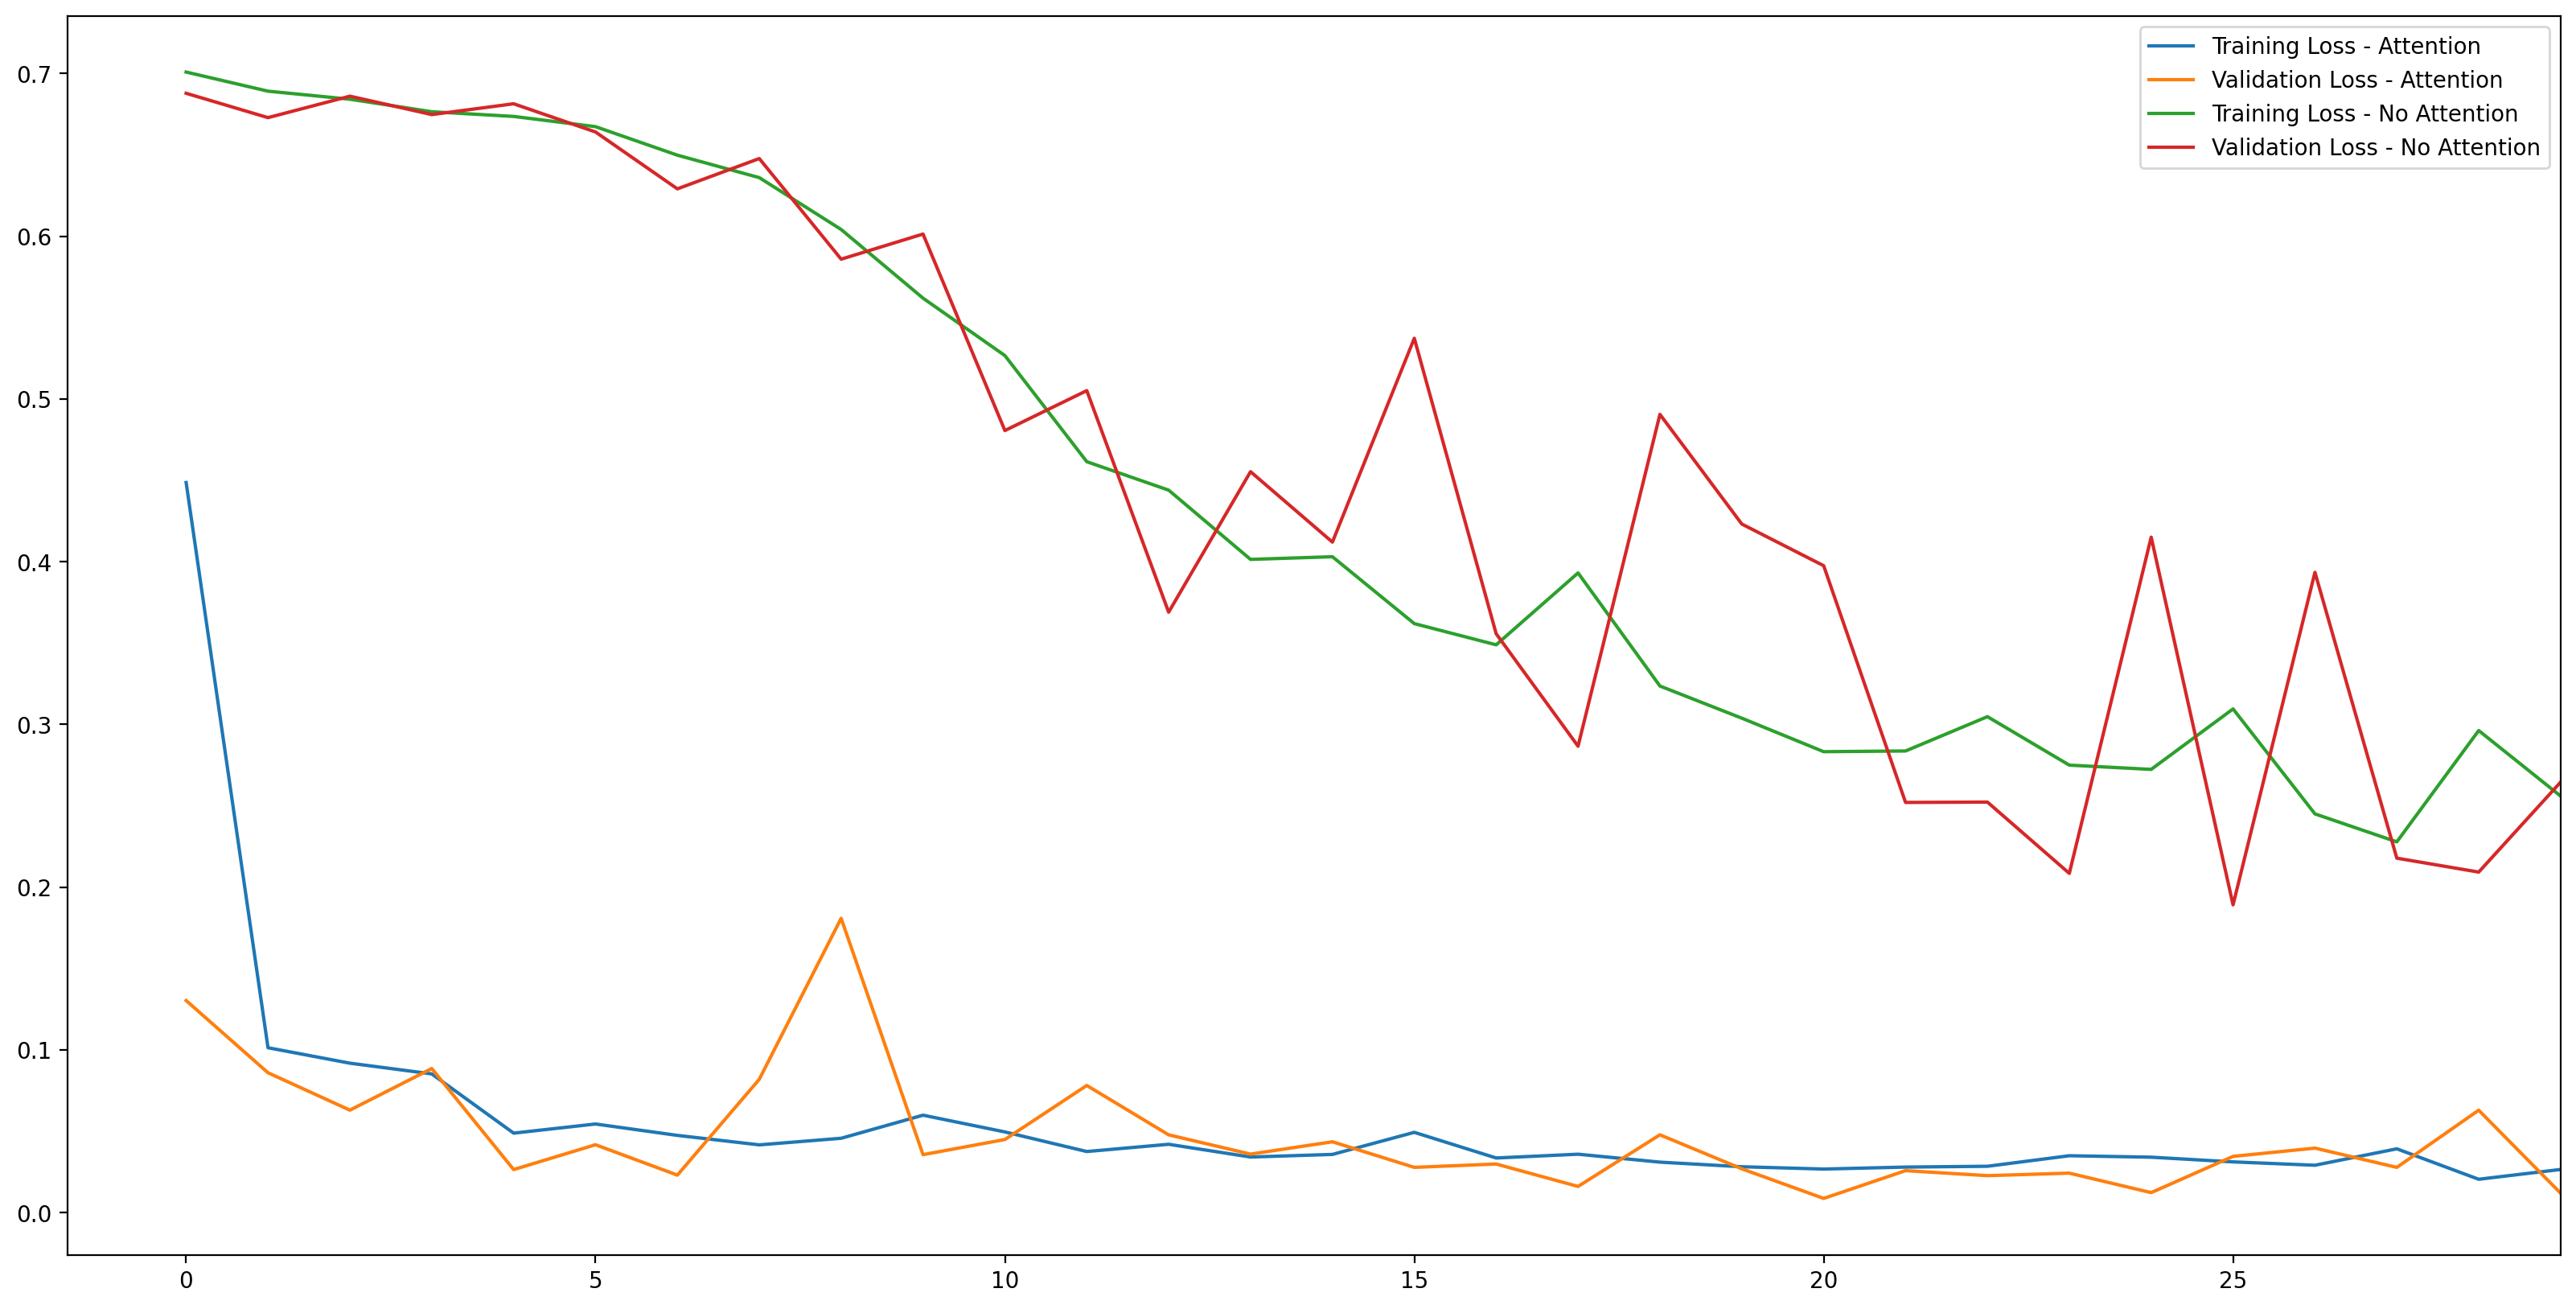

In [73]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(my_CBAM.loss_during_training,label='Training Loss - Attention')
ax.plot(my_CBAM.valid_loss_during_training,label='Validation Loss - Attention')
ax.plot(my_CBAM_NoAttention.loss_during_training,label='Training Loss - No Attention')
ax.plot(my_CBAM_NoAttention.valid_loss_during_training,label='Validation Loss - No Attention')
ax.legend()
ax.set_xlim(right=29)
fig.set_facecolor('white')